In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

In [2]:
def file_to_df(file_name):
    
    df = pd.read_csv('data/' + file_name + '.txt', sep = '\t', header = None)
    
    if df.isna().sum().sum():
        print(file_name + ' has null values')
    
    return df

In [3]:
pressure_1 = file_to_df('PS1')
pressure_2 = file_to_df('PS2')
pressure_3 = file_to_df('PS3')
pressure_4 = file_to_df('PS4')
pressure_5 = file_to_df('PS5')
pressure_6 = file_to_df('PS6')

temp_1 = file_to_df('TS1')
temp_2 = file_to_df('TS2')
temp_3 = file_to_df('TS3')
temp_4 = file_to_df('TS4')

vol_flow_1 = file_to_df('FS1')
vol_flow_2 = file_to_df('FS2')

motor_power = file_to_df('EPS1')
eff_factor = file_to_df('SE')
vibration = file_to_df('VS1')
cooling_power = file_to_df('CP')
cooling_eff = file_to_df('CE')

In [4]:
def mean_df(df):
    
    return df.mean(axis = 1)

In [5]:
PS1 = mean_df(pressure_1)
PS2 = mean_df(pressure_2)
PS3 = mean_df(pressure_3)
PS4 = mean_df(pressure_4)
PS5 = mean_df(pressure_5)
PS6 = mean_df(pressure_6)

FS1 = mean_df(vol_flow_1)
FS2 = mean_df(vol_flow_2)

TS1 = mean_df(temp_1)
TS2 = mean_df(temp_2)
TS3 = mean_df(temp_3)
TS4 = mean_df(temp_4)

EPS1 = mean_df(motor_power)
SE = mean_df(eff_factor)
VS1 = mean_df(vibration)
CP = mean_df(cooling_power)
CE = mean_df(cooling_eff)

In [6]:
X = pd.concat([PS1, PS2, PS3, PS4, PS5, PS6, 
              FS1, FS2,
              TS1, TS2, TS3, TS4,
              EPS1, SE, VS1, CP, CE], axis = 1)

feature_col = ['PS1', 'PS2', 'PS3', 'PS4', 'PS5', 'PS6', 
              'FS1', 'FS2',
              'TS1', 'TS2', 'TS3', 'TS4',
              'EPS1', 'SE', 'VS1', 'CP', 'CE']

X.columns = feature_col

In [7]:
conditions_col = ['cooler', 'valve', 'pump_leakage', 'hydraulic_accum', 'stable_flag']

y = file_to_df('profile')
y.columns = conditions_col

y['cooler'] = (y['cooler'] != 100)
y['valve'] = (y['valve'] != 100)
y['pump_leakage'] = (y['pump_leakage'] != 0)
y['hydraulic_accum'] = (y['hydraulic_accum'] != 130)
y['stable_flag'] = (y['stable_flag'] != 0)

<AxesSubplot:title={'center':'Correlation Matrix of Features'}>

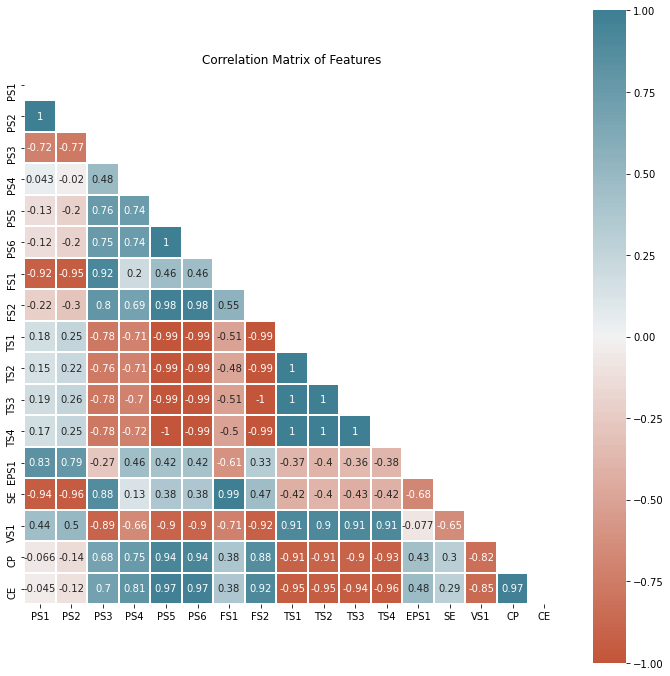

In [8]:
corr_matrix = X.corr()

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(20, 220, n = 200)

plt.figure(figsize = (12, 12))
plt.title('Correlation Matrix of Features')
sns.heatmap(corr_matrix, mask = mask, cmap = cmap, vmin = -1, vmax = 1, square = True, linewidths = 1, annot = True)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.6, random_state = 28)

sc = StandardScaler()
sc_X = sc.fit(X_train)
X_train = pd.DataFrame(sc_X.transform(X_train))
X_test = pd.DataFrame(sc_X.transform(X_test))
X_train.columns = feature_col
X_test.columns = feature_col

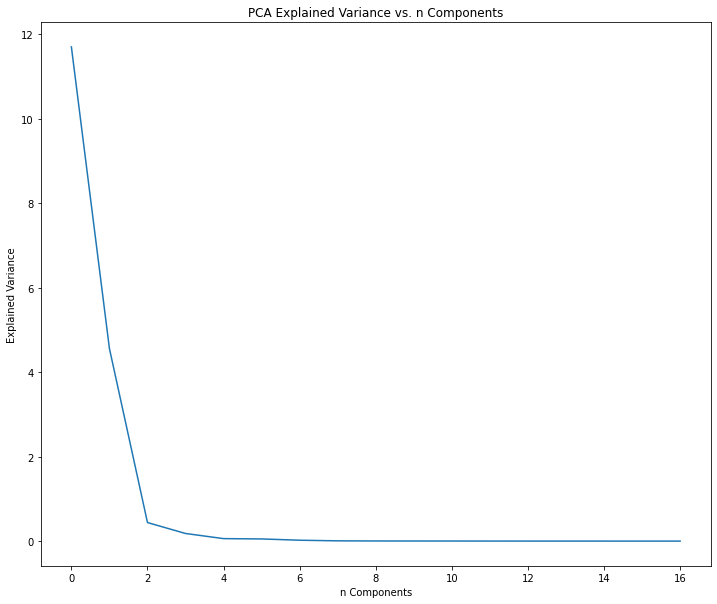

In [10]:
pca = PCA()
pca = pca.fit(X_train)

plt.figure(figsize = (12, 10))
plt.title('PCA Explained Variance vs. n Components')
plt.xlabel('n Components')
plt.ylabel('Explained Variance')
plt.plot(pca.explained_variance_)

In [11]:
pca_4 = PCA(4)
pca_4 = pca_4.fit(X_train)
X_train_pca = pca_4.transform(X_train)
X_test_pca = pca_4.transform(X_test)

In [12]:
for condition in conditions_col:
    xgb_ = xgb.sklearn.XGBClassifier(random_state = 42)
    xgb_.fit(X_train, y_train[condition])
    y_pred = xgb_.predict(X_test)
    cm = confusion_matrix(y_test[condition], y_pred)
    tp = cm[1][1]
    fn = cm[0][1]
    sens = tp / (tp + fn)
    print(condition, 'sensitivity is', sens)

cooler sensitivity is 1.0
valve sensitivity is 0.9625748502994012
pump_leakage sensitivity is 0.993322203672788
hydraulic_accum sensitivity is 0.9938271604938271
stable_flag sensitivity is 0.980440097799511


In [13]:
xgb_ = xgb.sklearn.XGBClassifier(random_state = 42)
params = {'max_depth' : np.arange(2, 11, 1 ),
         'learning_rate' : np.arange(0.01, 0.11, 0.01)}

for condition in conditions_col:
    clf_xgb = GridSearchCV(estimator = xgb_, param_grid = params, scoring = 'roc_auc')
    clf_xgb.fit(X_train, y_train[condition])
    print('The best parameters for ' + condition + ' are', clf_xgb.best_params_)

The best parameters for cooler are {'learning_rate': 0.08, 'max_depth': 2}
The best parameters for valve are {'learning_rate': 0.09, 'max_depth': 10}
The best parameters for pump_leakage are {'learning_rate': 0.08, 'max_depth': 3}
The best parameters for hydraulic_accum are {'learning_rate': 0.08, 'max_depth': 3}
The best parameters for stable_flag are {'learning_rate': 0.09999999999999999, 'max_depth': 6}


In [14]:
xgb_ = xgb.sklearn.XGBClassifier(random_state = 42)
params = {'max_depth' : np.arange(2, 11, 1 ),
         'learning_rate' : np.arange(0.01, 0.11, 0.01)}

for condition in conditions_col:
    clf_xgb = GridSearchCV(estimator = xgb_, param_grid = params, scoring = 'roc_auc')
    clf_xgb.fit(X_train_pca, y_train[condition])
    print('The best parameters for ' + condition + ' are', clf_xgb.best_params_)

The best parameters for cooler are {'learning_rate': 0.02, 'max_depth': 2}
The best parameters for valve are {'learning_rate': 0.09, 'max_depth': 9}
The best parameters for pump_leakage are {'learning_rate': 0.09999999999999999, 'max_depth': 5}
The best parameters for hydraulic_accum are {'learning_rate': 0.09, 'max_depth': 8}
The best parameters for stable_flag are {'learning_rate': 0.060000000000000005, 'max_depth': 8}


In [15]:
param_list = [[0.08, 2], [0.09, 10], [0.08, 3], [0.08, 3], [0.1, 6]]
param_list_pca = [[0.02, 2], [0.09, 9], [0.1, 5], [0.09, 8], [0.06, 8]]
counter = 0

for params in param_list:
    lr = params[0]
    md = params[1]
    condition = conditions_col[counter]
    counter += 1
    xgb_ = xgb.sklearn.XGBClassifier(random_state = 42, learning_rate = lr, max_depth = md)
    xgb_.fit(X_train, y_train[condition])
    y_pred = xgb_.predict(X_test)
    cm = confusion_matrix(y_test[condition], y_pred)
    tp = cm[1][1]
    fn = cm[0][1]
    sens = tp / (tp + fn)
    print(condition, 'sensitivity is', sens)

cooler sensitivity is 1.0
valve sensitivity is 0.9623493975903614
pump_leakage sensitivity is 0.9933110367892977
hydraulic_accum sensitivity is 0.9867075664621677
stable_flag sensitivity is 0.9805825242718447


In [16]:
param_list = [[0.08, 2], [0.09, 10], [0.08, 3], [0.08, 3], [0.1, 6]]
param_list_pca = [[0.02, 2], [0.09, 9], [0.1, 5], [0.09, 8], [0.06, 8]]
counter = 0

for params in param_list_pca:
    lr = params[0]
    md = params[1]
    condition = conditions_col[counter]
    counter += 1
    xgb_ = xgb.sklearn.XGBClassifier(random_state = 42, learning_rate = lr, max_depth = md)
    xgb_.fit(X_train_pca, y_train[condition])
    y_pred = xgb_.predict(X_test_pca)
    cm = confusion_matrix(y_test[condition], y_pred)
    tp = cm[1][1]
    fn = cm[0][1]
    sens = tp / (tp + fn)
    print(condition, 'sensitivity is', sens)

cooler sensitivity is 0.9988950276243094
valve sensitivity is 0.7844228094575799
pump_leakage sensitivity is 0.9733333333333334
hydraulic_accum sensitivity is 0.9616548940464178
stable_flag sensitivity is 0.9439024390243902
